In [5]:
%matplotlib notebook
from __future__ import division
from matplotlib.pyplot import plot, ylabel, xlabel, yscale, xscale, legend, subplots, gca, gcf
from matplotlib.ticker import FormatStrFormatter
from IPython.display import IFrame

In [6]:
import numpy as np
import gzip
import cPickle
from scipy.optimize import minimize
from climin.util import optimizer
from itertools import repeat, cycle, islice, izip
import random
inf = float("inf")

In [7]:
from breze.learn.data import one_hot
from breze.learn.base import cast_array_to_local_type
from schlichtanders.myfunctools import compose, meanmap, summap, compose_fmap, Average
from schlichtanders import myfunctools
from schlichtanders.mygenerators import eatN, chunk, chunk_list, every, takeN
from schlichtanders.myplot import add_val, add_point

In [9]:
import theano_models as tm
import theano_models.deterministic_models as dm
import theano_models.probabilistic_models as pm
import theano
import theano.tensor as T
from theano.printing import debugprint
from theano.tensor.shared_randomstreams import RandomStreams

In [10]:
from sqlalchemy import Column, Integer, Unicode, UnicodeText, String, PickleType, Float
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base

In [11]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [13]:
tm.inputting_references.update(['to_be_randomized'])
tm.inputting_references, tm.outputting_references

({'extra_inputs',
  'flat',
  'inputs',
  'n_data',
  'parameters',
  'parameters_positive',
  'parameters_psumto1',
  'to_be_randomized'},
 {'kl_prior', 'loglikelihood', 'norm_det', 'norm_dets', 'outputs'})

In [14]:
from schlichtanders.myobjects import NestedNamespace

# Data

In [15]:
datafile = '../data/mnist.pkl.gz'
# Load data.        a                                                                                           

with gzip.open(datafile,'rb') as f:                                                                        
    train_set, val_set, test_set = cPickle.load(f)                                                       

X, Z = train_set                                                                                               
VX, VZ = val_set
TX, TZ = test_set

Z = one_hot(Z, 10)
VZ = one_hot(VZ, 10)
TZ = one_hot(TZ, 10)

# from UncertainWeightsPaper rescaled the data,
# however it already seems to be normalized
# X /= 126  
# VX /= 126
# TX /= 126
# X *= 2
# VX *= 2
# TX *= 2

image_dims = 28, 28

X, Z, VX, VZ, TX, TZ = [cast_array_to_local_type(i) for i in (X, Z, VX,VZ, TX, TZ)]
map(np.shape, [X, Z, VX, VZ, TX, TZ])

[(50000, 784),
 (50000, 10),
 (10000, 784),
 (10000, 10),
 (10000, 784),
 (10000, 10)]

# Hyperparameters

In [16]:
engine = create_engine('sqlite:///hyperparameters.db')
Base = declarative_base(bind=engine)

class RandomHyper(Base):
    __tablename__ = 'hyper'
    id = Column(Integer, primary_key=True)
    
    # hyper parameters:
    n_epochs = Column(Integer)
    batch_size = Column(Integer)
    average_n = Column(Integer)
    units_per_layer = Column(Integer)
    pi = Column(Float)
    minus_log_s1 = Column(Integer)
    minus_log_s2 = Column(Integer)
    
    n_normflows = Column(Integer)
    
    opt_identifier = Column(String)
    opt_momentum = Column(Float)
    opt_offset = Column(Float)
    opt_decay = Column(Float)
    opt_step_rate = Column(Float)
    
    # results:
    best_val_loss = Column(Float)
    best_parameters = Column(PickleType, nullable=True)
    train_loss = Column(PickleType)
    val_loss = Column(PickleType)

    def __init__(self):
        # hyper parameters:
        self.n_epochs = 20
        self.batch_size = 128
        self.average_n = 1
        self.units_per_layer = np.random.choice([400, 800, 1200], p=[0.5, 0.3, 0.2])
        self.pi = random.choice([1/4, 1/2, 3/4])
        self.minus_log_s1 = random.choice([0,1,2])
        self.minus_log_s2 = random.choice([6,7,8])
        
        self.n_normflows = random.choice([1,2,3,4,8,32])
        
        self.opt_identifier = random.choice(["adadelta", "adam", "rmsprop"])
        if self.opt_identifier == "adadelta":
            self.opt_momentum = random.choice([np.random.uniform(0, 0.01), np.random.uniform(0.9, 1)])
            self.opt_offset = random.choice([5e-5, 1e-8])
            self.opt_step_rate = random.choice([1, 1e-3, 1e-4, 1e-5])
        elif self.opt_identifier == "adam":
            self.opt_momentum = random.choice([np.random.uniform(0, 0.01), np.random.uniform(0.8, 0.93)])
            self.opt_offset = 10 ** -np.random.uniform(3, 4)
            self.opt_step_rate = random.choice([1e-3, 1e-4, 1e-5])
        elif self.opt_identifier == "rmsprop":
            self.opt_momentum = random.choice([np.random.uniform(0.002, 0.008), np.random.uniform(0.9, 1)])
            self.opt_offset = np.random.uniform(0, 0.000045)
            self.opt_step_rate = random.choice([1e-3, 1e-4, 1e-5])
        self.opt_decay = np.random.uniform(0.78, 1)
        
        self.init_results()
    
    def init_results(self):
        # extra for being able to reset results for loaded hyperparameters
        self.best_parameters = None
        self.best_val_loss = inf
        self.train_loss = []
        self.val_loss = []

Base.metadata.create_all()
Session = sessionmaker(bind=engine)
sql_session = Session()
hyper = RandomHyper()
hyper.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f39a2f19190>,
 'average_n': 1,
 'batch_size': 128,
 'best_parameters': None,
 'best_val_loss': inf,
 'mapreduce': 'summap',
 'minus_log_s1': 0,
 'minus_log_s2': 6,
 'n_epochs': 20,
 'n_normflows': 2,
 'opt_decay': 0.8921101559667562,
 'opt_identifier': 'adam',
 'opt_momentum': 0.8230536276942046,
 'opt_offset': 0.0007807802738183761,
 'opt_step_rate': 0.0001,
 'pi': 0.5,
 'train_loss': [],
 'units_per_layer': 1200,
 'val_loss': []}

# Model

In [29]:
Flatten = tm.as_proxmodel("to_be_randomized")(tm.prox_flatten)

## data modelling

In [30]:
# this is extremely useful to tell everything the default sizes
input = tm.as_tensor_variable(X[0], name="X")

In [31]:
predictor = dm.Mlp(
    input=input,
    output_size=Z.shape[1],
    output_transfer="softmax",
    hidden_sizes=[hyper.units_per_layer]*2,
    hidden_transfers=["rectifier"]*2
)
predictor

Mlp3 { 'inputs': [AffineNonlinear7.X],
  'outputs': AffineNonlinear9.outputs,
  'parameters': [ AffineNonlinear7.weights,
                  AffineNonlinear7.bias,
                  AffineNonlinear8.weights,
                  AffineNonlinear8.bias,
                  AffineNonlinear9.weights,
                  AffineNonlinear9.bias]}

In [32]:
target_distribution = pm.Categorical(predictor)
target_distribution

Categorical3 { 'inputs': [],
  'outputs': Categorical3.outputs,
  'parameters_psumto1': [AffineNonlinear9.outputs]}

In [33]:
targets = tm.Merge(target_distribution, predictor, Flatten(predictor['parameters']))
targets

Merge3 { 'inputs': [AffineNonlinear7.X],
  'outputs': Categorical3.outputs,
  'parameters': [],
  'parameters_psumto1': [],
  'to_be_randomized': "AffineNonlinear7.weights:AffineNonlinear7.bias:AffineNonlinear8.weights:AffineNonlinear8.bias:AffineNonlinear9.weights:AffineNonlinear9.bias"}

## parameter modelling

In [39]:
total_size = tm.total_size(targets['to_be_randomized'])

In [40]:
params_base = pm.DiagGauss(output_size=total_size)  
# if you want to use size directly, CAUTION, you need to copy before!
# params_base.map('parameters_positive', reparameterize_map(squareplus, squareplus_inv), 'parameters')
params_base

DiagGauss2 { 'inputs': [],
  'outputs': DiagGauss2.outputs,
  'parameters': [DiagGauss2.mean],
  'parameters_positive': [DiagGauss2.var]}

In [41]:
normflows = [dm.PlanarTransform() for _ in range(hyper.n_normflows)]
normflows

[PlanarTransform3 { 'inputs': [PlanarTransform3.inputs.0],
   'norm_det': PlanarTransform3.norm_det,
   'outputs': PlanarTransform3.outputs,
   'parameters': [PlanarTransform3.b, PlanarTransform3.w, PlanarTransform3._u]},
 PlanarTransform4 { 'inputs': [PlanarTransform4.inputs.0],
   'norm_det': PlanarTransform4.norm_det,
   'outputs': PlanarTransform4.outputs,
   'parameters': [PlanarTransform4.b, PlanarTransform4.w, PlanarTransform4._u]}]

In [42]:
params = params_base
for transform in normflows:
    params = tm.normalizing_flow(transform, params)  # returns transform, however with adapted logP    

params

normalized_flow4 { 'inputs': [],
  'norm_det': PlanarTransform4.norm_det,
  'outputs': PlanarTransform4.outputs,
  'parameters': [ PlanarTransform4.b,
                  PlanarTransform4.w,
                  PlanarTransform4._u,
                  PlanarTransform3.b,
                  PlanarTransform3.w,
                  PlanarTransform3._u,
                  DiagGauss2.mean],
  'parameters_positive': [DiagGauss2.var]}

## bayes

In [43]:
g1 = pm.Gauss(total_size, init_var=np.exp(-2* hyper.minus_log_s1))
g2 = pm.Gauss(total_size, init_var=np.exp(-2* hyper.minus_log_s2))
prior = pm.Mixture(g1, g2, mixture_probs=[hyper.pi, 1-hyper.pi])
# label hyper parameters accordingly
prior = tm.Merge(prior,
              parameters=None, # mean is not adapted at all, but left centred at zero
              parameters_positive='hyperparameters_positive',
              parameters_psumto1='hyperparameters_psumto1')
prior

Merge9 { 'hyperparameters_positive': [Gauss.var, Gauss2.var],
  'hyperparameters_psumto1': [Mixture.mixture_probs],
  'inputs': [],
  'outputs': Mixture.outputs}

In [44]:
model = tm.variational_bayes(targets, 'to_be_randomized', params, priors=prior)
model

variational_lower_bound { 'hyperparameters_positive': [Gauss.var, Gauss2.var],
  'hyperparameters_psumto1': [Mixture.mixture_probs],
  'inputs': [AffineNonlinear7.X],
  'kl_prior': variational_lower_bound.kl_prior,
  'logposterior': variational_lower_bound.logposterior,
  'logprior': variational_lower_bound.logprior,
  'n_data': variational_lower_bound.n_data,
  'norm_det': PlanarTransform4.norm_det,
  'outputs': Categorical3.outputs,
  'parameters': [ PlanarTransform4.b,
                  PlanarTransform4.w,
                  PlanarTransform4._u,
                  PlanarTransform3.b,
                  PlanarTransform3.w,
                  PlanarTransform3._u,
                  DiagGauss2.mean],
  'parameters_positive': [DiagGauss2.var],
  'parameters_psumto1': []}

In [45]:
# model = Merge(model, Reparameterize(model['parameters_positive'], squareplus, squareplus_inv))
# UncertainWeights uses softplus parameterization
parameters = tm.prox_reparameterize(model['parameters_positive'], tm.softplus, tm.softplus_inv)
parameters += model['parameters']
flat = tm.prox_flatten(tm.prox_center(parameters))

# Optimizer

In [46]:
# dm.InvertibleModel.INVERTIBLE_MODELS
tm.reduce_all_identities()
# dm.InvertibleModel.INVERTIBLE_MODELS

Climin wants an iterator of (args, kwarsg) as keyword argument "args" (to be passed to the loss function). Concretley, we use an infinite iterator over minibatches.

In [47]:
n_batches = X.shape[0] // hyper.batch_size  # after this many steps we went through the whole data set once

climin_args = izip(izip(chunk(hyper.batch_size, cycle(Z)), chunk(hyper.batch_size, cycle(X))), repeat({}))

def weights_regularizer_1epoch():
    for i in range(1, n_batches+1):
        yield 2**(n_batches - i) / (2**n_batches - 1)
        
assert len(list(weights_regularizer_1epoch())) == n_batches

In [48]:
# mapreduce = summap
# if hyper.average_n > 1:
#     mapreduce = compose_fmap(Average(hyper.average_n), mapreduce)

loss = tm.loss_variational(model)
optimizer_kwargs = tm.numericalize(
    loss, flat,
    batch_mapreduce=summap,
    annealing_combiner=tm.AnnealingCombiner(
        weights_regularizer=cycle(weights_regularizer_1epoch())
    ),
    adapt_init_params=lambda ps: ps + np.random.normal(size=ps.size, scale=0.01),
    mode='FAST_RUN'
)

In [49]:
opt = optimizer(
    identifier=hyper.opt_identifier,
    step_rate=hyper.opt_step_rate,
    momentum=hyper.opt_momentum,
    decay=hyper.opt_decay,
    offset=hyper.opt_offset,
    
    args=climin_args,
    **tm.climin_kwargs(optimizer_kwargs)
)

batch_precompile
batch_precompile


/home/stephan/GitProjects/climin/climin/util.py:151: UserWarning: Argument named f is not expected by <class 'climin.adam.Adam'>
  % (i, klass))


# Visualized Fit

<IPython.core.display.Javascript object>


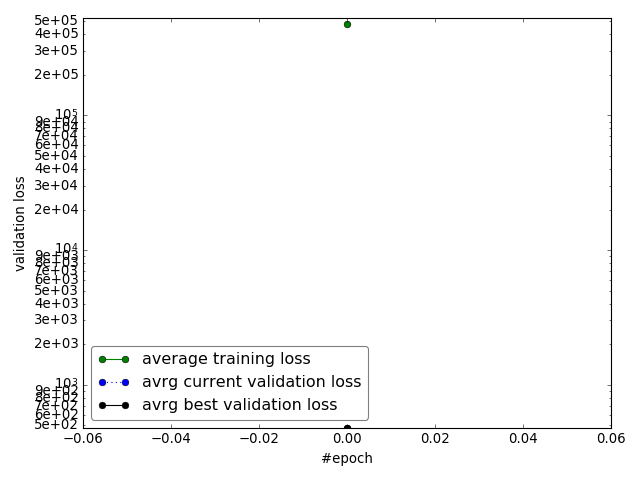

In [50]:
# plot: 
line_train, = plot([], [], 'go-', label="average training loss")
line_curr_val, = plot([],[], 'bo:', label="avrg current validation loss")
line_best_val, = plot([], [], 'ko-', label="avrg best validation loss")
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
yscale('log')
gca().yaxis.set_minor_formatter(FormatStrFormatter("%.2g"))
ylabel("validation loss")
xlabel("#epoch")
legend(loc='lower left', fancybox=True, framealpha=0.5)

# start values:
val_loss = optimizer_kwargs['num_loss'](optimizer_kwargs['num_parameters'], VZ, VX, no_annealing=True)
training_loss = optimizer_kwargs['num_loss'](optimizer_kwargs['num_parameters'], Z[:10], X[:10], no_annealing=True)
start_epoch = opt.n_iter//n_batches

add_point(line_best_val, start_epoch, val_loss)
add_point(line_curr_val, start_epoch, val_loss)
add_point(line_train, start_epoch, training_loss)

In [51]:
for info in takeN(hyper.n_epochs, every(n_batches, opt)):
    current_epoch = info['n_iter']//n_batches
    # collect and visualize validation loss for choosing the best model
    val_loss = optimizer_kwargs['num_loss'](opt.wrt, VZ, VX, no_annealing=True)
    if val_loss < hyper.best_val_loss:
        hyper.best_parameters = opt.wrt
        hyper.best_val_loss = val_loss
        add_point(line_best_val, current_epoch, val_loss)
    hyper.val_loss.append(val_loss)
    add_point(line_curr_val, current_epoch, val_loss)
    
    # visualize training loss for comparison:
    training_loss = optimizer_kwargs['num_loss'](opt.wrt, Z[:10], X[:10], no_annealing=True)
    hyper.train_loss.append(training_loss)
    add_point(line_train, current_epoch, training_loss)
    
#     print info['n_iter'], training_loss, val_loss, best_val_loss

KeyboardInterrupt: 

In [ ]:
sql_session.add(hyper)
sql_session.commit()

# Performance

In [ ]:
print best_val_loss
predict = theano.function([flat] + model['inputs'], model['outputs'])
def mypredict(x):
    return Average(10)(predict, hyper.best_parameters, x)
mypredict(X[0]), Z[0]

In [ ]:
PX = np.apply_along_axis(mypredict, 1, X)
PVX = np.apply_along_axis(mypredict, 1, VX)
PTX = np.apply_along_axis(mypredict, 1, TX)

In [ ]:
# print 'incorrect samples train/val/test:  %i/%i/%i' % (
#     (PX[:, :10].argmax(1) != Z.argmax(1)).sum(),
#     (PVX[:, :10].argmax(1) != VZ.argmax(1)).sum(),
#     (PTX[:, :10].argmax(1) != TZ.argmax(1)).sum())

print 'error rate train/val/test:  %g/%g/%g' % (
    (PX[:, :10].argmax(1) != Z.argmax(1)).mean(),
    (PVX[:, :10].argmax(1) != VZ.argmax(1)).mean(),
    (PTX[:, :10].argmax(1) != TZ.argmax(1)).mean())